In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
leakage_dataset_train_100 = pd.read_csv(r"Leakage Detection\leakage_dataset_train_100.csv")
leakage_dataset_validation_1000 = pd.read_csv(r"Leakage Detection\leakage_dataset_validation_1000.csv")

In [3]:
X_train = leakage_dataset_train_100[['mfc1', 'mfc2', 'mfc3', 'mfc4']].to_numpy()
Y_train = leakage_dataset_train_100[['y1', 'y2']].to_numpy()

In [4]:
X_validation = leakage_dataset_validation_1000[['mfc1', 'mfc2', 'mfc3', 'mfc4']].to_numpy()
Y_validation = leakage_dataset_validation_1000[['y1', 'y2']].to_numpy()

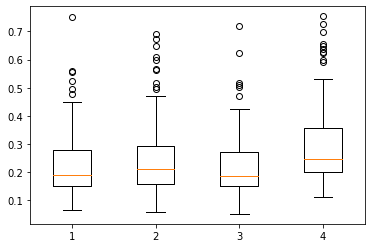

In [5]:
%matplotlib inline
B = plt.boxplot(X_train)
plt.show()

In [6]:
list_whisker = [item.get_ydata() for item in B['whiskers']]
list_whisker

[array([0.15104118, 0.06433784]),
 array([0.27953555, 0.4504011 ]),
 array([0.15927049, 0.0595173 ]),
 array([0.2926093 , 0.46881146]),
 array([0.15077288, 0.05122426]),
 array([0.27253617, 0.42546578]),
 array([0.20039553, 0.11240221]),
 array([0.35654869, 0.53036271])]

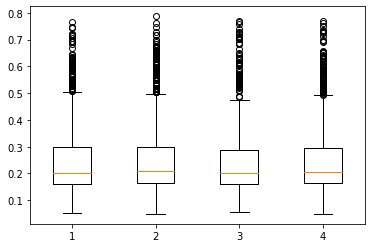

In [7]:
%matplotlib inline
B1 = plt.boxplot(X_validation)
plt.show()

In [8]:
list_whisker_val = [item.get_ydata() for item in B1['whiskers']]
list_whisker_val

[array([0.16234618, 0.05349716]),
 array([0.2993559 , 0.50403049]),
 array([0.16344416, 0.04891348]),
 array([0.29840857, 0.49760057]),
 array([0.16077478, 0.05659426]),
 array([0.28779415, 0.47630593]),
 array([0.16270096, 0.04941728]),
 array([0.29547214, 0.49441948])]

In [9]:
diff1 = list_whisker[-2][1] - list_whisker_val[-2][1]
diff2 = list_whisker[-1][1] - list_whisker_val[-1][1]
diff = (diff1+diff2)/2
diff

0.049464080536921334

In [10]:
X_train[:,-1] = X_train[:,-1] - diff
X_train[:,:-1] = X_train[:,:-1] + diff/3

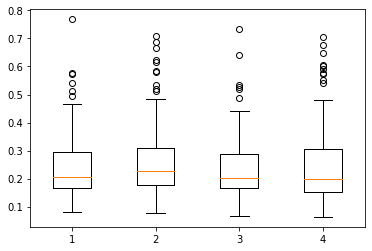

[array([0.16752921, 0.08082586]),
 array([0.29602357, 0.46688912]),
 array([0.17575852, 0.07600533]),
 array([0.30909733, 0.48529949]),
 array([0.16726091, 0.06771229]),
 array([0.28902419, 0.44195381]),
 array([0.15093145, 0.06293813]),
 array([0.30708461, 0.48089863])]

In [11]:
%matplotlib inline
B2 = plt.boxplot(X_train)
plt.show()
list_whisker_new = [item.get_ydata() for item in B2['whiskers']]
list_whisker_new

Implementing rotation via linear matrix operator

In [12]:
def rotate90(x, y):
    x_new = tf.gather(x, [3,0,1,2])
    rotation_matrix = np.array([[0, -1], [1, 0]])
    y_new = tf.squeeze(tf.matmul(tf.reshape(y, (1,2)), rotation_matrix))
    return x_new, y_new

def rotate180(x, y):
    x_new = tf.gather(x, [2,3,0,1])
    rotation_matrix = np.array([[-1, 0], [0, -1]])
    y_new = tf.squeeze(tf.matmul(tf.reshape(y, (1,2)), rotation_matrix))
    return x_new, y_new

def rotate270(x, y):
    x_new = tf.gather(x, [1,2,3,0])
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    y_new = tf.squeeze(tf.matmul(tf.reshape(y, (1,2)), rotation_matrix))
    return x_new, y_new

def flip(x, y):
    x_new = tf.gather(x, [1,0,3,2])
    y_new = [y[0], -1*y[1]]
    return x_new, y_new

def flip90(x, y):
    x_flipped, y_flipped = flip(x, y)
    x_rotated, y_rotated = rotate90(x_flipped, y_flipped)
    return x_rotated, y_rotated

def flip180(x, y):
    x_flipped, y_flipped = flip(x, y)
    x_rotated, y_rotated = rotate180(x_flipped, y_flipped)
    return x_rotated, y_rotated

def flip270(x, y):
    x_flipped, y_flipped = flip(x, y)
    x_rotated, y_rotated = rotate270(x_flipped, y_flipped)
    return x_rotated, y_rotated

In [14]:
dataset100 = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset100_augmented = dataset100
for augmentation in (rotate90, rotate180, rotate270, flip, flip90, flip180, flip270):
    dataset_temp = dataset100.map(augmentation)
    dataset100_augmented = dataset100_augmented.concatenate(dataset_temp)

In [15]:
dataset100_augmented.cardinality().numpy()

800

In [46]:
X_train_augmented = np.asarray([ x[0] for x in list(dataset100.as_numpy_iterator())])
Y_train_augmented = np.asarray([ x[1] for x in list(dataset100.as_numpy_iterator())])

In [49]:
tf.random.set_seed(42)
class HiddenLayer(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(HiddenLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        
        initializer = tf.keras.initializers.RandomNormal(stddev=0.2)
        self.a = self.add_weight(shape = (), initializer = initializer, trainable = True)
        self.b = self.add_weight(shape = (), initializer = initializer, trainable = True)
        self.c = self.add_weight(shape = (), initializer = initializer, trainable = True)

    def call(self, inputs):
        W1 = [[self.a, self.b, self.c, self.b],
              [self.b, self.a, self.b, self.c],
              [self.c, self.b, self.a, self.b],
              [self.b, self.c, self.b, self.a]]
        return tf.matmul(inputs, W1)

In [50]:
tf.random.set_seed(42)
class OutputLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(OutputLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        
        initializer = tf.keras.initializers.RandomNormal(stddev=0.2)
        self.d = self.add_weight(shape = (), initializer = initializer, trainable = True)
        
    def call(self, inputs):
        first_term = self.d * tf.reduce_sum(inputs * [1, -1, -1, 1], axis=1, keepdims=True)
        second_term = self.d * tf.reduce_sum(inputs * [-1, -1, 1, 1], axis=1, keepdims=True)
        return tf.concat([first_term, second_term], axis=1)

In [51]:
#Defining the Model 
model_equivariant = tf.keras.Sequential()
model_equivariant.add(HiddenLayer())
model_equivariant.add(HiddenLayer())
model_equivariant.add(OutputLayer())

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_equivariant.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])
model_equivariant.fit(X_train_augmented, Y_train_augmented, epochs=100, batch_size=32, validation_data=(X_validation, Y_validation), callbacks=[stop_early])

Epoch 1/100


C:\Users\ak066\AppData\Roaming\Python\Python38\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


4/4 [==============================] - 2s 97ms/step - loss: 0.3449 - mean_absolute_error: 0.5084 - val_loss: 0.3311 - val_mean_absolute_error: 0.5004
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.3449 - mean_absolute_error: 0.5084 - val_loss: 0.3311 - val_mean_absolute_error: 0.5004
Epoch 3/100
4/4 [==============================] - 0s 33ms/step - loss: 0.3449 - mean_absolute_error: 0.5084 - val_loss: 0.3307 - val_mean_absolute_error: 0.5001
Epoch 4/100
4/4 [==============================] - 0s 28ms/step - loss: 0.3443 - mean_absolute_error: 0.5080 - val_loss: 0.3295 - val_mean_absolute_error: 0.4992
Epoch 5/100
4/4 [==============================] - 0s 30ms/step - loss: 0.3428 - mean_absolute_error: 0.5068 - val_loss: 0.3268 - val_mean_absolute_error: 0.4971
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 0.3391 - mean_absolute_error: 0.5041 - val_loss: 0.3214 - val_mean_absolute_error: 0.4929
Epoch 7/100
4/4 [=======================

In [52]:
model_equivariant.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (HiddenLayer)  (None, 4)                 3         
                                                                 
 hidden_layer_1 (HiddenLayer  (None, 4)                3         
 )                                                               
                                                                 
 output_layer (OutputLayer)  (None, 2)                 1         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [19]:
for layer in model_equivariant.layers: print(layer.get_config(), layer.get_weights())

{'name': 'hidden_layer', 'trainable': True, 'dtype': 'float32'} [0.61037385, -0.10241961, -0.8150131]
{'name': 'hidden_layer_1', 'trainable': True, 'dtype': 'float32'} [0.73451215, 0.023153387, -0.6882054]
{'name': 'output_layer', 'trainable': True, 'dtype': 'float32'} [-0.85360867]


In [53]:
model_equivariant.save('model_equivariant_augmented.h5')

ValueError: Unable to create dataset (name already exists)